#### Logistic models: $$p(y=1|x)=\sigma(wx+b)$$
$$\begin{aligned}
\bigg\{\begin{array}{l}y=1,\ if\ p(y=1|x)>=0.5\\
y=0,\ else
\end{array}
\end{aligned}$$
#### Bayesian inference:$$p(\theta|x, y)\propto{p(\theta)p(y|x, \theta)},\ where\ \theta = (w, b)$$

### 1. Bayesian Logistic Regression klqp

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from edward.models import Bernoulli, Normal

### 2. Data generation and plot

In [2]:
def build_toy_dataset(N, noise_std=0.1):
    X = np.random.uniform(-10, 10, size=[N, 2])
    y = 2*X[:, 0] - X[:, 1] + np.random.normal(5, 0.3, size=N)
    y[y < 0.0] = 0
    y[y > 0.0] = 1
    return X, y

N = 300  # number of data points
# DATA
ed.set_seed(42)
X_train, y_train = build_toy_dataset(N)

### 3. Logistic model 
#### (define the prior $p(\theta)=p(w)p(b)$ as Normal)

In [3]:
# MODEL
X = tf.placeholder(tf.float32, [N, 2])
# Normal priors
w = Normal(loc=tf.zeros(2), scale=3.0 * tf.ones(2))
b = Normal(loc=tf.zeros([]), scale=3.0 * tf.ones([]))
y = Bernoulli(logits=ed.dot(X, w) + b)

### 4. Define the posterior 
#### Posterior $q(\theta;\lambda)$, we wish $q(\theta;\lambda)$ to approximate the real posterior $p(\theta|x, y)$ via variational inference

In [4]:
# Posteriors
qw_loc = tf.Variable(tf.random_normal([2]))
qw_scale = tf.nn.softplus(tf.Variable(tf.random_normal([2])))
qb_loc = tf.Variable(tf.random_normal([]) + 10)
qb_scale = tf.nn.softplus(tf.Variable(tf.random_normal([])))

qw = Normal(loc=qw_loc, scale=qw_scale)
qb = Normal(loc=qb_loc, scale=qb_scale)

### 5. Sample 10 models from the randomly initialized posteriors

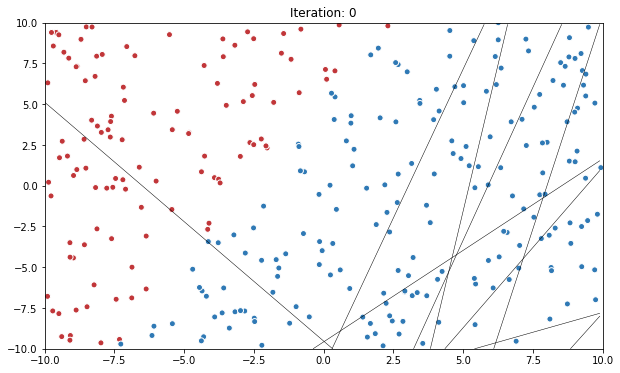

In [6]:
# Sample 10 initialized models
xx1, xx2 = np.mgrid[-10:10:.1, -10:10:.1]
grid = np.c_[xx1.ravel(), xx2.ravel()]
grid = tf.constant(grid, dtype=tf.float32)
models = tf.stack([tf.sigmoid(ed.dot(grid, qw.sample())+qb.sample()) for _ in range(10)])

sess = ed.get_session()
sess.run(tf.global_variables_initializer())
outputs = sess.run(models)

outputs = [i.reshape(xx1.shape) for i in outputs]
# FIRST VISUALIZATION (prior)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0")

ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")
for i in range(10):
    ax.contour(xx1, xx2, outputs[i], levels=[.5], cmap="Greys", vmin=0, vmax=.1, linewidths=0.5)

ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.legend()
plt.show()

### 6. Training 

In [7]:
inference = ed.KLqp({w: qw, b: qb}, data={X: X_train, y: y_train})
# Run model for 2000 iterations with 50 batch size
inference.run(n_iter=2000, n_samples=50)

2000/2000 [100%] ██████████████████████████████ Elapsed: 18s | Loss: 20.407


### 7. Sample 10 models after training

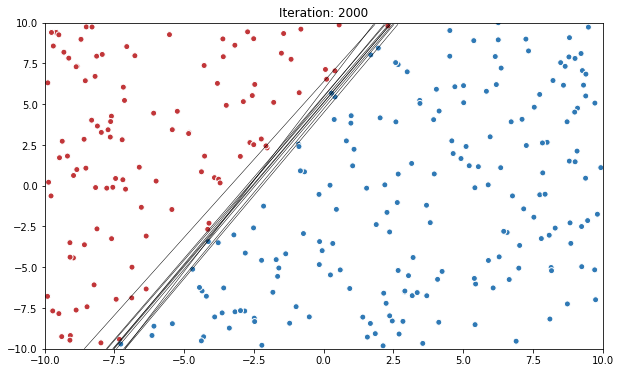

In [8]:
outputs = sess.run(models)

outputs = [i.reshape(xx1.shape) for i in outputs]
# FIRST VISUALIZATION (prior)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 2000")

ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")
for i in range(10):
    ax.contour(xx1, xx2, outputs[i], levels=[.5], cmap="Greys", vmin=0, vmax=.1, linewidths=0.5)

ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.legend()
plt.show()

### 8. Posterior density plot (Note that the propotion of posterior means is approximately 2:-1:5)

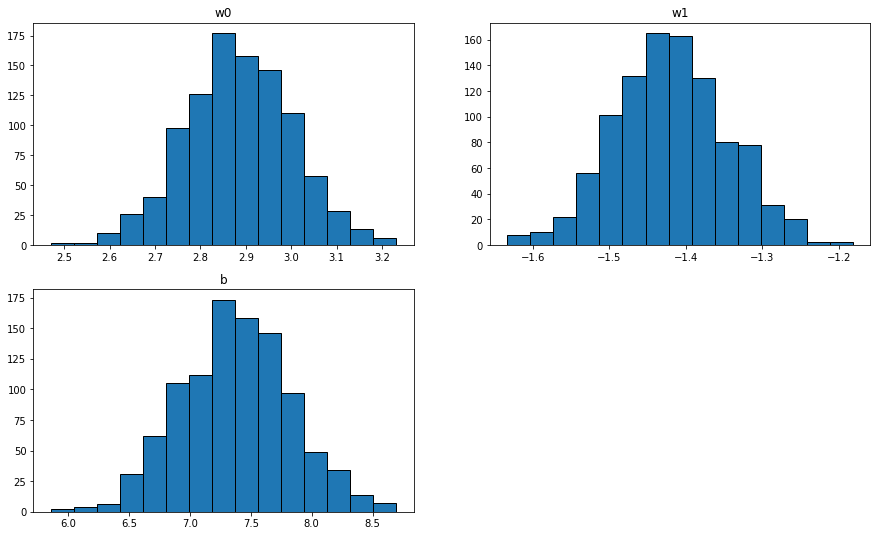

In [9]:
posterior_w = qw.sample(1000).eval()
b_val = qb.sample(1000).eval()
w0, w1 = [i[0] for i in posterior_w], [i[1] for i in posterior_w]
plt.figure(figsize=(15, 9))

plt.subplot(2, 2, 1)
plt.title("w0")
plt.hist(w0, bins=15, edgecolor='black')

plt.subplot(2, 2, 2)
plt.title("w1")
plt.hist(w1, bins=15, edgecolor='black')

plt.subplot(2, 2, 3)
plt.title("b")
plt.hist(b_val, bins=15, edgecolor='black')
plt.show()